# Control continuo con Deep Reinforcement Learning para Cuadricoptero

In [1]:
import numpy as np
import gym
from gym import spaces
from numpy import pi
#!/usr/bin/env python3
from scipy.integrate import odeint
from numpy import sin, cos, tan, tanh
from numpy.linalg import norm

## Sistema dinámico

In [2]:
# constantes
G = 9.81
I = (4.856*10**-3, 4.856*10**-3, 8.801*10**-3)
B, M, L = 1.140*10**(-6), 1.433, 0.225
K = 0.001219  # kt
omega_0 = np.sqrt((G * M)/(4 * K))

In [3]:
def f(y, t, w1, w2, w3, w4):
    #El primer parametro es un vector
    #W tambien
    z,w = y
    dz = w
    W = [w1, w2 , w3 , w4]
    dw = G - (K/M) * norm(W) ** 2
    #dw = (-2*K/M)*omega_0*(w1 + w2 + w3 + w4)
    return dz, dw

def f(y, t, w1, w2, w3, w4):
    #El primer parametro es un vector
    #W,I tambien
    u, v, w, p, q, r, psi, theta, phi, x, y, z = y
    Ixx, Iyy, Izz = I
    W = np.array([w1, w2, w3, w4])
    du = r * v - q * w - G * sin(theta)
    dv = p * w - r * u - G * cos(theta) * sin(phi)
    dw = q * u - p * v + G * cos(phi) * cos(theta) - (K/M) * norm(W) ** 2
    dp = ((L * B) / Ixx) * (w4 ** 2 - w2 ** 2) - q * r * ((Izz - Iyy) / Ixx)
    dq = ((L * B) / Iyy) * (w3 ** 2 - w1 ** 2) - p * r * ((Ixx - Izz) / Iyy)
    dr = (B / Izz) * (w2 ** 2 + w4 ** 2 - w1 ** 2 - w3 ** 2)
    dpsi = (q * sin(phi) + r * cos(phi)) * (1 / cos(theta))
    dtheta = q * cos(phi) - r * sin(phi)
    dphi = p + (q * sin(phi) + r * cos(phi)) * tan(theta)
    dx = u
    dy = v
    dz = w
    return du, dv, dw, dp, dq, dr, dpsi, dtheta, dphi, dx, dy, dz
    # return dz, dw

## Diseño del ambiente, step y reward

In [4]:
# constantes del ambiente
Vel_Max = 55 #Velocidad maxima de los motores
Vel_Min = 50
Low_obs = np.array([0,-10])#z,w
High_obs = np.array([100,10])

Tiempo_max = 20
tam = 60

In [5]:
r2 = lambda z, w : (1 - tanh(z)) * w 

"""Quadcopter Environment that follows gym interface"""

class QuadcopterEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    def __init__(self):
        self.action_space = spaces.Box(low = Vel_Min * np.ones(1), high = Vel_Max*np.ones(1))
        self.observation_space = spaces.Box(low = Low_obs, high = High_obs)
        self.i = 0
        # self.state = np.array([10,0]) #z,w
        self.state = self.reset()
        self.time = np.linspace(0, Tiempo_max, tam)
        self.z_e = 15

    def reward_f(self):
        z, w = self.state
        if z <= 0:
            return -1e4
        else:
            return -np.linalg.norm([z-self.z_e , r2(abs(z - self.z_e), w)])

    def is_done(self):
        #Si se te acabo el tiempo
        if self.i == tam-2:
            return True
        elif self.reward_f() < -1e3:
            return True
        elif self.reward_f() > -1e-3:
            return True
        elif not (self.state[0] > 0 or self.state[0] < 100):
            return True
        else:
            return False

    def step(self,action):
        #import pdb; pdb.set_trace()
        w1, w2, w3, w4 = action
        t = [self.time[self.i], self.time[self.i+1]]
        delta_y = odeint(f, self.state, t, args=(w1, w2, w3, w4))[1]
        self.state = delta_y
        reward = self.reward_f()
        done = self.is_done()
        self.i += 1
        return delta_y, reward, done

    def reset(self):
        self.i = 0
        self.state = np.array([10,0])
        # self.state = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10])
        return self.state
        
    def render(self, mode='human', close=False):
        pass

In [6]:
def control_feedback(x, y, F):
    '''
    Realiza el control lineal de las velocidades W
    dadas las variables (x, y).
    param x: variable independiente (dx = y)
    param y: variable dependiente
    param F: matriz 2x4 de control
    regresa: W = w1, w2, w3, w4 
    '''
    A = np.array([x, y]).reshape((2, 1))
    return np.dot(F, A).reshape((4,))

## Proceso Ornstein-Ulhenbeck para la exploración

$$\mu(s_t) = \mu(s_t | \theta_t^{\mu}) + \mathcal{N}$$

In [7]:
import numpy as np
import gym
from collections import deque
import random

# Ornstein-Ulhenbeck Process
# Taken from #https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py
class OUNoise(object):
    def __init__(self, action_space, mu=53.69, theta=0.15, max_sigma=5.0, min_sigma=0.0, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
        
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)


class NormalizedEnv(QuadcopterEnv): #(gym.ActionWrapper):
    """ Wrap action """ #Recibe un ambiente
    def __init__(self, env):
        QuadcopterEnv.__init__(self)
        
    
    def _action(self, action):
        act_k = (self.action_space.high - self.action_space.low)/ 2.
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k * action + act_b

    def _reverse_action(self, action):
        act_k_inv = 2./(self.action_space.high - self.action_space.low)
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k_inv * (action - act_b)
    

## Replay Buffer, almacenamiento de la transición

In [8]:
class Memory:
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size)
    
    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)
        
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

    def __len__(self):
        return len(self.buffer)

# Diseño de arquitecturas para DDPG
Parámetros: 
$$
\begin{align*}
\theta^Q &: \text{ Q network} \\
\theta^{\mu}&: \text{ Deterministic policy function} \\
\theta^{Q'} &: \text{ target Q network} \\
\theta^{\mu '}&: \text{ target policy function}
\end{align*}
$$

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.autograd
from torch.autograd import Variable

class Critic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)

    def forward(self, state, action):
        """
        Params state and actions are torch tensors
        """
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)

        return x
    

class Actor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, learning_rate = 3e-4):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, state):
        """
        Param state is a torch tensor
        """
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))

        return x

# Diseño del agente y función de entrenamiento

In [10]:
import torch
import torch.autograd
import torch.optim as optim
import torch.nn as nn
#from model import *
#from utils import *

class DDPGagent:
    def __init__(self, env, hidden_size=256, actor_learning_rate=1e-4, critic_learning_rate=1e-3, gamma=0.99, tau=1e-2, max_memory_size=50000):
        # Params
        self.num_states = env.observation_space.shape[0]
        self.num_actions = env.action_space.shape[0]
        self.gamma = gamma
        self.tau = tau

        # Networks
        self.actor = Actor(self.num_states, hidden_size, self.num_actions)
        self.actor_target = Actor(self.num_states, hidden_size, self.num_actions)
        self.critic = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)
        self.critic_target = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)

        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
        
        # Training
        self.memory = Memory(max_memory_size)        
        self.critic_criterion  = nn.MSELoss()
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=actor_learning_rate)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_learning_rate)
    
    def get_action(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        action = self.actor.forward(state)
        action = action.detach().numpy()[0,0]
        return action
    
    def update(self, batch_size):
        states, actions, rewards, next_states, _ = self.memory.sample(batch_size)
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
    
        # Critic loss        
        Qvals = self.critic.forward(states, actions)
        next_actions = self.actor_target.forward(next_states)
        next_Q = self.critic_target.forward(next_states, next_actions.detach())
        Qprime = rewards + self.gamma * next_Q
        critic_loss = self.critic_criterion(Qvals, Qprime)

        # Actor loss
        policy_loss = -self.critic.forward(states, self.actor.forward(states)).mean()
        
        # update networks
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        self.critic_optimizer.zero_grad()
        critic_loss.backward() 
        self.critic_optimizer.step()

        # update target networks 
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))
       
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

## Prueba de control en z y w

env = QuadcopterEnv()
#env = NormalizedEnv(gym.make("Pendulum-v0"))
env = NormalizedEnv(env)
agent = DDPGagent(env)
noise = OUNoise(env.action_space)
batch_size = 20
rewards = []
avg_rewards = []

import sys

for episode in range(1000):
    state = env.reset()
    noise.reset()
    episode_reward = 0
    step = 0
    while True:
        action = agent.get_action(state)
        #import pdb; pdb.set_trace()
        action = noise.get_action(action, step)
        actions = action * np.ones(4)
        # new_state, reward, done, _ = env.step(action) # pendulo
        new_state, reward, done = env.step(actions) 
        agent.memory.push(state, action, reward, new_state, done)
        if len(agent.memory) > batch_size:
            agent.update(batch_size)        
        state = new_state
        episode_reward += reward
        if done:
            print('state: ',env.state, 'reward:', reward)
            sys.stdout.write("episode: {}, reward: {}, average _reward: {} \n".format(episode, np.round(episode_reward, decimals=2), np.mean(rewards[-10:])))
            break
            
    step += 1

    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[-10:]))


/usr/local/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


episode: 0, reward: -729.91, average _reward: nan 
[53.50643873  4.896978  ]
episode: 100, reward: -10178.95, average _reward: -4035.8324367971386 
[-0.2811859  -2.59970259]
episode: 200, reward: -2408.11, average _reward: -5461.663638568336 
[142.05742045  12.8960631 ]
episode: 300, reward: -2537.61, average _reward: -2117.8138366609296 
[164.90167544  16.83127609]
episode: 400, reward: -429.63, average _reward: -4159.89808078123 
[23.29654337 -0.46330059]
episode: 500, reward: -328.66, average _reward: -3403.684903634846 
[18.40744333 -0.27870452]
episode: 600, reward: -3770.1, average _reward: -1998.355979884874 
[208.77219127  19.57555125]
episode: 700, reward: -664.72, average _reward: -4212.62120335903 
[44.22863312  3.01884169]
episode: 800, reward: -233.49, average _reward: -3716.888892809972 
[15.75402837  2.83591601]
episode: 900, reward: -2978.1, average _reward: -3533.4518505808364 
[172.69748333  14.92587164]
428.49842715263367


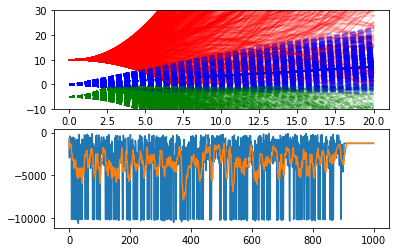

In [11]:
import matplotlib.pyplot as plt
from time import time
import sys

c1 = (((2*K)/M) * omega_0)**(-1)
W0 = np.array([1, 1, 1, 1]).reshape((4,)) * omega_0


F1 = np.array([[0.25, 0.25, 0.25, 0.25], [1, 1, 1, 1]]).T 

fig, ((ax1, ax2)) = plt.subplots(2, 1)

env = QuadcopterEnv()
#env = NormalizedEnv(gym.make("Pendulum-v0"))
env = NormalizedEnv(env)
agent = DDPGagent(env)
noise = OUNoise(env.action_space)
batch_size = 50
rewards = []
avg_rewards = []

t1 = time()
for episode in range(1000):
    state = env.reset()
    noise.reset()
    episode_reward = 0
    #for step in range(499):
    R = [-5]
    W = [0]
    Z = [10]
    t = env.time
    A = [50]
    while True:
        action = agent.get_action(state)
        action = noise.get_action(action, env.i)
        if episode > 900:
            noise.max_sigma = 0.0
        # new_state, reward, done, _ = env.step(action) # pendulo
        # W1 = control_feedback(env.state[0]-env.z_e, env.state[1], F1) * c1
        # control = W1 + W0
        # new_state, reward, done = env.step(control)
        new_state, reward, done = env.step(action*np.ones(4)) 
        agent.memory.push(state, action, reward, new_state, done)
        #print(len(agent.memory),batch_size,len(agent.memory) > batch_size )
        if len(agent.memory) > batch_size:
            agent.update(batch_size)
            if episode > 0:
                z,w = state
                W.append(w)
                Z.append(z)
                R.append(reward)
                A.append(float(action))
                # A.append(float(control[0]))
        state = new_state
        episode_reward += reward
        if done:
            if episode % 25 == 0:
                sys.stdout.write("episode: {}, reward: {}, average _reward: {} \n".format(episode, np.round(episode_reward, decimals=2), np.mean(rewards[-10:])))
                print(env.state)
            break
    #writer.add_scalar('Episode vs  Episode_Reward', episode, episode_reward)
    if episode > 0:
        t = t[0:len(Z)]
        ax1.set_ylim(-10, 30)
        ax1.plot(t,Z,'-r',t,W,'--b',t,R,'--g',t,A,alpha = 0.2)
    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[-10:]))

ax2.plot(rewards)
ax2.plot(avg_rewards)
#plt.xlabel('Episode')
#plt.ylabel('Reward')
#plt.show()
t2 = time()
print(t2-t1)
plt.show()

#writer.close()




plt.plot(rewards)
plt.plot(avg_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()